In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
%matplotlib inline

Load raw calibration data

In [2]:
# Name of file with calibration data
cal_file = "../data/9_28_21/9_28_21_calibration2.lvm"

# Load data with pandas read_csv function
cal_data = pd.read_csv(
    cal_file,      # load file
    sep = '\t',    # define separator
    skiprows = 23, # skip labview junk
    usecols=np.arange(1,7), # select columns with relevant data
    names = [      # rename columns for make_regression function
        'yellow_g', 'red_g', 'blue_g', # gauges
        'yellow_p', 'red_p', 'blue_p', # pots
    ]
)

In [3]:
cal_data

,yellow_g,red_g,blue_g,yellow_p,red_p,blue_p
0,4.323592,4.577590,4.415512,2.333839,1.139864,1.823249
1,4.322292,4.577915,4.413563,2.331241,1.138240,1.821625
2,4.320343,4.578564,4.410640,2.331890,1.138565,1.822274
3,4.316121,4.580189,4.409340,2.331241,1.137591,1.820650
4,4.320668,4.574017,4.413238,2.331241,1.137915,1.821300
...,...,...,...,...,...,...
7775,1.887885,2.490394,2.143180,0.734836,0.465899,0.502602
7776,1.888534,2.489095,2.145129,0.735485,0.465575,0.502277
7777,1.887560,2.490394,2.147727,0.736135,0.466224,0.502602
7778,1.890808,2.490070,2.146753,0.737434,0.468173,0.504226


Make linear regression model with sklearn

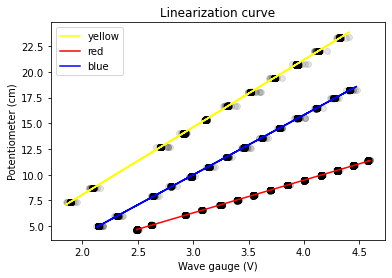

In [11]:
def make_regression(data, color, plot = True):
    """
    Uses sklearn linear regression tool to make linear models for each wave gauge
        data - pandas DataFrame with specific column naming convention
        color - color of wave gauge/pot unit
        plot - decides whether or not to make a plot of the result
    Returns: 
        Linear regression model
        
    """
    # values converts it into a numpy array
    # -1 means that calculate the dimension of rows, but have 1 column
    
    X = data.loc[:, color + "_g"].values.reshape(-1, 1) # voltage as input
    Y = data.loc[:, color + "_p"].values.reshape(-1, 1) * 10 # potentiometer "height" as output
    linear_regressor = LinearRegression()
    model = linear_regressor.fit(X, Y)
    
    if plot:
        plt.scatter(X, Y, color = 'k', alpha = 0.1)
        plt.plot(X, model.predict(X), color = color, label = color)
        plt.ylabel("Potentiometer (cm)")
        plt.xlabel("Wave gauge (V)")
        plt.title("Linearization curve")
        plt.legend()
    return model

yellow_model = make_regression(cal_data, "yellow")
red_model = make_regression(cal_data, "red")
blue_model = make_regression(cal_data, "blue")

Take sklearn model and put it in y=mx+b form, store as `lambda` function

In [23]:
def model_func(model):
    '''
    extract line equation from sklearn linear regression
    '''
    # Slope of line is rise / run, run = 1
    b = model.predict([[0]]).tolist()[0][0]
    m = model.predict([[1]]).tolist()[0][0] - b
    
    # Return line with no intercept - assumes data is centered on mean
    return lambda x: m * x

yellow = model_func(yellow_model)
blue = model_func(blue_model)
red = model_func(red_model)

Load wave data, center on mean

(50.0, 100.0)

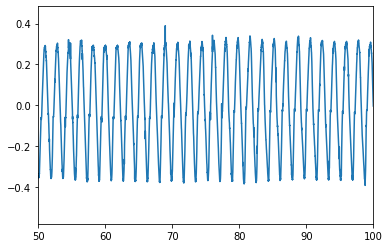

In [13]:
data_file = "../data/9_28_21/9_28_21_waves_5_1.8.lvm"
wave_data = pd.read_csv(
    data_file,
    sep = '\t', 
    skiprows = 23, 
    usecols = [0,1,2,3], 
    names = ['time', 'yellow', 'red', 'blue'],
    index_col = 0
)

# center on mean
wave_data = wave_data.apply(lambda x: x-x.mean())

plt.plot(wave_data["yellow"])
plt.xlim([50, 100]) # seconds

In [14]:
wave_data

,yellow,red,blue
time,,,
0.00,0.180255,0.293588,-0.376423
0.01,0.175708,0.294887,-0.377072
0.02,0.173434,0.290990,-0.381295
0.03,0.179930,0.333539,-0.371875
0.04,0.172135,0.329966,-0.378047
...,...,...,...
329.05,0.025323,0.170162,-0.027583
329.06,0.021750,0.170812,-0.030831
329.07,0.026947,0.168538,-0.032455


Turn voltages into heights with respective calibration curves

In [15]:
wave_height = pd.DataFrame()
wave_height['yellow'] = wave_data['yellow'].apply(yellow)
wave_height['blue'] = wave_data['blue'].apply(blue)
wave_height['red'] = wave_data['red'].apply(red)

In [16]:
wave_height

,yellow,blue,red
time,,,
0.00,1.181176,-2.192078,0.932980
0.01,1.151380,-2.195858,0.937108
0.02,1.136479,-2.220450,0.924724
0.03,1.179046,-2.165593,1.059938
0.04,1.127967,-2.201536,1.048584
...,...,...,...
329.05,0.165938,-0.160627,0.540750
329.06,0.142525,-0.179542,0.542815
329.07,0.176580,-0.188999,0.535589


(200.0, 250.0)

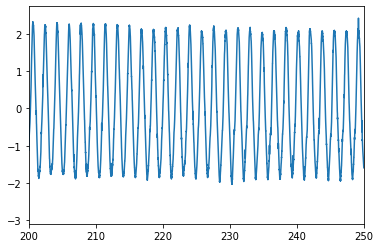

In [28]:
plt.plot(wave_height["blue"])
plt.xlim([200, 250]) # seconds